# Self-supervised contrastive learning with SimSiam
**Author**: Sayak Paul

**Description**: Implementation of a self-supervised learning method for computer vision.

https://keras.io/examples/vision/simsiam/

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

In [ ]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 4
EPOCHS = 5
CROP_TO = 128
SEED = 26

PROJECT_DIM = 2048
LATENT_DIM = 512
WEIGHT_DECAY = 0.0005

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    return image


def color_jitter(x, strength=[0.4, 0.9, 0.6, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image

def load_image_from_path(path):
    
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, size = (IMG_WIDTH, IMG_HEIGHT))
    
    return image

def procces_image_from_path(path):
    return custom_augment(load_image_from_path(path))

def flip_random_crop_from_path(path):
    return flip_random_crop(load_image_from_path(path))

def resize_from_path(path):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, size = (CROP_TO, CROP_TO))
    
    return image

In [ ]:
df = pd.read_csv('aux_cluster.csv')

In [ ]:
X_train = ['./dataset/database-full/' + x for x in os.listdir('./dataset/database-full/') if x not in df.ID]

In [ ]:
X_val = np.array(['./dataset/database-full/' + filename for filename in df.ID])
y_val = df.new_cluster.values.reshape(-1, 1)

In [ ]:
def balance(X, y_, limit=15):
    
    balanced_X = []
    balanced_y = []
    
    y = y_.squeeze()
    for i in range(y.max()):
        if( len(y[y == i]) > limit):
            balanced_X.append(X[y == i][:limit])
            balanced_y.append(y[y == i][:limit])
        else:
            balanced_X.append(X[y == i])
            balanced_y.append(y[y == i])
            
    return np.array([y for x in balanced_X for y in x]), np.array([[y] for x in balanced_y for y in x])

In [ ]:
X_val, y_val = balance(X_val, y_val)

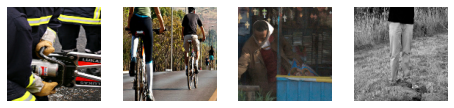

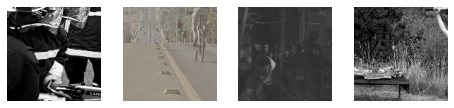

In [ ]:
ssl_ds_one = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(procces_image_from_path, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


ssl_ds_two = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(procces_image_from_path, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

# Visualize a few augmented images.
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(4):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(4):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

In [ ]:
import resnet_cifar10_v2

N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1


def get_encoder():
    # Input and backbone.
    inputs = layers.Input((CROP_TO, CROP_TO, 3))
    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(
        inputs
    )
    x = resnet_cifar10_v2.stem(x)
    x = resnet_cifar10_v2.learner(x, NUM_BLOCKS)
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)

    # Projection head.
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    outputs = layers.BatchNormalization()(x)
    return tf.keras.Model(inputs, outputs, name="encoder")


def get_predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(
                LATENT_DIM,
                use_bias=False,
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
            ),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model


In [ ]:
def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))

In [ ]:
class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super(SimSiam, self).__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


Epoch 1/5
7946/7946 [==============================] - 1183s 148ms/step - loss: -0.9220
Epoch 2/5
7946/7946 [==============================] - 1255s 158ms/step - loss: -0.9599
Epoch 3/5
7946/7946 [==============================] - 1255s 158ms/step - loss: -0.9663
Epoch 4/5
7946/7946 [==============================] - 1328s 167ms/step - loss: -0.9716
Epoch 5/5
7946/7946 [==============================] - 1251s 157ms/step - loss: -0.9722


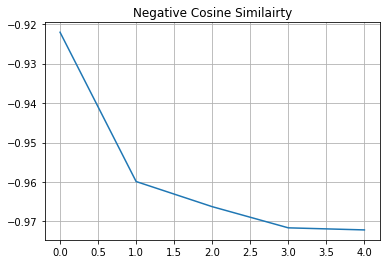

In [ ]:
# Create a cosine decay learning scheduler.
num_training_samples = len(X_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# Compile model and start training.
simsiam = SimSiam(get_encoder(), get_predictor())
simsiam.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = simsiam.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

# OJO, segun la página:

If your solution gets very close to -1 (minimum value of our loss) very quickly with a different dataset and a different backbone architecture that is likely because of representation collapse. It is a phenomenon where the encoder yields similar output for all the images. In that case additional hyperparameter tuning is required especially in the following areas:

    Strength of the color distortions and their probabilities.
    Learning rate and its schedule.
    Architecture of both the backbone and their projection head.


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_val, y_val, stratify = y_val, test_size=0.33, random_state=42)

In [ ]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop_from_path(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = test_ds.map(lambda x, y: (resize_from_path(x), y), num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone ResNet20.
backbone = tf.keras.Model(
    simsiam.encoder.input, simsiam.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
backbone.trainable = False
inputs = layers.Input((CROP_TO, CROP_TO, 3))
x = backbone(inputs, training=False)
outputs = layers.Dense(167, activation="softmax")(x)
linear_model = tf.keras.Model(inputs, outputs, name="linear_model")

# Compile model and start training.
linear_model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
history = linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/5
234/234 [==============================] - 11s 39ms/step - loss: 6.6229 - accuracy: 0.0032 - val_loss: 6.5266 - val_accuracy: 0.0130
Epoch 2/5
234/234 [==============================] - 8s 33ms/step - loss: 6.5390 - accuracy: 0.0096 - val_loss: 6.4950 - val_accuracy: 0.0195
Epoch 3/5
234/234 [==============================] - 8s 32ms/step - loss: 6.5033 - accuracy: 0.0150 - val_loss: 6.4814 - val_accuracy: 0.0281
Epoch 4/5
234/234 [==============================] - 8s 35ms/step - loss: 6.4799 - accuracy: 0.0171 - val_loss: 6.4745 - val_accuracy: 0.0238
Epoch 5/5
116/116 [==============================] - 3s 24ms/step - loss: 6.4701 - accuracy: 0.0281
Test accuracy: 2.81%


In [ ]:
queries = pd.read_csv('names_test_queries.csv', header=None)

In [ ]:
queries = np.array(['./dataset/database-full/' + name for name in queries.values]).squeeze()

In [ ]:
queries_dataset = tf.data.Dataset.from_tensor_slices(queries)
queries_dataset = (
    queries_dataset
    .map(resize_from_path)
    .batch(4)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
preds = linear_model.predict(queries_dataset, verbose=1)

216/216 [==============================] - 5s 20ms/step


In [ ]:
preds.argmax(1)

array([32, 98,  6, 14,  6, 45, 14, 45, 98, 98, 98, 14, 32, 14, 32, 98, 32,
       14, 98,  1, 32, 14, 98, 14, 98, 32, 14, 32, 45, 45, 98,  6, 32,  6,
       45, 98, 98, 14, 98,  6,  6, 45, 98, 32, 14, 98, 98, 45, 14, 32,  6,
       32,  6,  6,  6, 32, 98, 32, 98,  1, 98, 14, 32,  6, 32, 32, 98, 98,
       45, 98, 98, 98,  1, 32, 32, 45, 14,  6,  6, 98, 45, 45, 98, 14,  6,
       14, 45,  1,  1, 98,  3,  6,  6, 98,  6, 98, 32, 32, 98,  6, 98,  1,
       32, 98, 98, 14,  6, 98, 14, 45, 98,  6, 45, 45,  6, 14, 98,  6, 32,
       98, 32, 98, 14, 32, 14, 98,  3,  6, 45, 14, 32, 45,  6, 45, 32,  6,
       14, 32, 32, 98, 32,  6, 45, 98, 45, 98, 32, 45, 32,  1, 98, 45, 98,
       32,  6, 14, 98, 98, 32, 14, 45, 32,  6, 45, 32, 98,  6, 98, 98, 45,
       32, 32, 45, 45, 32, 14, 45, 14, 14,  3, 98, 32, 98,  6, 32, 32, 14,
       32, 45, 32,  6, 32,  6,  1, 98, 32, 14, 98, 32, 45, 98, 98,  6, 98,
       32, 14, 14, 98, 32,  6, 45,  6, 14, 45, 45, 98, 98, 14,  6, 98, 14,
        6, 98, 45, 14, 45

In [ ]:
# aux = y_val.copy()
# aux = aux.squeeze()
# for i in range(167):
#     print(f"Size of {i} label: ", len(aux[aux == i]))

In [ ]:
linear_model.summary()

Model: "linear_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 model_1 (Functional)        (None, 256)               568368    
                                                                 
 dense_5 (Dense)             (None, 167)               42919     
                                                                 
Total params: 611,287
Trainable params: 42,919
Non-trainable params: 568,368
_________________________________________________________________


In [ ]:
X_all = ['./dataset/database-full/' + x for x in os.listdir('./dataset/database-full/')]

all_dataset = tf.data.Dataset.from_tensor_slices(X_all)
all_dataset = (
    all_dataset
    .map(resize_from_path)
    .batch(4)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
preds_all = linear_model.predict(all_dataset)

In [ ]:
m = tf.keras.Sequential([l for l in linear_model.layers[:-1]])

In [ ]:
encode_preds = m.predict(all_dataset)

In [ ]:
result_SimSIAM = pd.DataFrame({'paths': X_all, 'cluster': preds_all.argmax(1), 'encode': [x for x in encode_preds]})

In [ ]:
result_SimSIAM.to_csv('result_SimSIAM.csv', index=None)

In [ ]:
result_SimSIAM

,paths,cluster,encode
0,./dataset/database-full/ image0.jpg,45,"[0.0088265855, -0.054712776, 0.040945727, 0.05..."
1,./dataset/database-full/ image1.jpg,14,"[0.015162552, -0.039470147, 0.044202168, 0.062..."
2,./dataset/database-full/ image10.jpg,98,"[-0.029453693, -0.086752824, 0.08823047, 0.064..."
3,./dataset/database-full/ image100.jpg,98,"[-0.014115915, -0.06781546, 0.065508254, 0.057..."
4,./dataset/database-full/ image1000.jpg,14,"[0.01355737, -0.030045658, 0.025909383, 0.0627..."
...,...,...,...
31778,./dataset/database-full/ image9995.jpg,45,"[0.019572265, -0.0710073, 0.0636301, 0.0735466..."
31779,./dataset/database-full/ image9996.jpg,45,"[-0.008633392, -0.07349238, 0.05880566, 0.0633..."
31780,./dataset/database-full/ image9997.jpg,98,"[-0.023086667, -0.07726155, 0.073589265, 0.063..."
31781,./dataset/database-full/ image9998.jpg,14,"[0.01473823, -0.04920204, 0.044522144, 0.05690..."


In [ ]:
from sklearn.metrics import pairwise_distances
from tqdm import tqdm

def sorting(tup, reverse=True):
    return(sorted(tup, key = lambda x: x[0],reverse=reverse))

for query in tqdm(queries):
    cluster = result_SimSIAM[result_SimSIAM.paths == query].cluster.values[0]
    
    neighborhood = result_SimSIAM[(result_SimSIAM.cluster == cluster) & (result_SimSIAM.paths != query)]
    neighborhood_latents = np.array(neighborhood.encode.values)
    query_latent = result_SimSIAM[result_SimSIAM.paths == query].encode.values[0]
    
    neighborhood_latents = np.array([x for x in neighborhood_latents])
    
    dist = pairwise_distances(query_latent.reshape(1, -1), neighborhood_latents, metric = 'euclidean')[0] 
    dist_path = [(x, y) for x, y in zip(dist, neighborhood.paths)]
    
    sorted_dist_path = np.array(sorting(dist_path, False))[:,1][:100]
    indices = result_SimSIAM[result_SimSIAM.paths == query].index
    
    sorted_dist_path = [x[30:-4] for x in sorted_dist_path]
    to_add = " ".join(sorted_dist_path)
    
    result_SimSIAM.loc[indices, 'most_similars'] = to_add

100%|████████████████████████████████████████████████████████████████████████████████| 861/861 [00:50<00:00, 17.12it/s]


In [ ]:
IDs = [x[30:-4] for x in result_SimSIAM[result_SimSIAM.paths.isin(queries)].paths.values]
Expecteds = result_SimSIAM[result_SimSIAM.paths.isin(queries)].most_similars

In [ ]:
submit_df = pd.DataFrame({'Id': IDs, 'Expected':Expecteds}).set_index('Id')

In [ ]:
indices_queries = [x[30:-4] for x in queries]

In [ ]:
final_submit = pd.DataFrame(columns=['Id', 'Expected'])
for i in indices_queries:
    final_submit = final_submit.append(submit_df[submit_df.index == i])

In [ ]:
final_submit = final_submit.reset_index().drop('Id', axis=1).rename(columns={'index':'Id'}).set_index('Id')

In [ ]:
final_submit.to_csv("SimSIAM_EUCLIDEAN.csv")